In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import sqlite3
from sklearn import svm
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Loading in tiled data (genomes)

#Xtrain = np.load("/home/swz/PGP-work/Lightning_Work/PGPFiles/hiq-pgp-1hot")
ohinfo = np.load("/home/swz/PGP-work/Lightning_Work/PGPMagicTileSet/names.npy")
#ohPaths = np.load("/home/swz/PGP-work/Lightning_Work/PGPFiles/hiq-pgp-1hot-info")
Xtrain = np.load("/home/swz/PGP-work/Lightning_Work/PGPMagicTileSet/hiq-pgp")
justVarPaths = np.load("/home/swz/PGP-work/Lightning_Work/PGPMagicTileSet/hiq-pgp-info")

In [3]:
# Loading in phenotype data from PGP database

conn = sqlite3.connect('/home/swz/PGP-work/Lightning_Work/Database/untap.db')
c = conn.cursor()
c.execute('SELECT * FROM demographics')
rows = c.fetchall()
colnames = [(i[0]) for i in c.description]
data = pd.DataFrame(rows,columns=colnames)
conn.close()

In [4]:
# Find ids for phenotypes with blood type
dataBloodType = data[['human_id','blood_type']]
dataBloodType= dataBloodType.replace('', np.nan, inplace=False)
dataBloodType = dataBloodType.dropna(axis=0, how='any', inplace=False)

# Creating dummy variables for A, B and rh factor
dataBloodType['A'] = dataBloodType['blood_type'].str.contains('A',na=False).astype(int)
dataBloodType['B'] = dataBloodType['blood_type'].str.contains('B',na=False).astype(int)
dataBloodType['Rh'] = dataBloodType['blood_type'].str.contains('\+',na=False).astype(int)

dataBloodType

,human_id,blood_type,A,B,Rh
0,hu43860C,O+,0,0,1
1,huC30901,O-,0,0,0
2,hu9385BA,A+,1,0,1
3,hu04FD18,O+,0,0,1
4,huAE6220,B+,0,1,1
5,hu604D39,AB+,1,1,1
6,hu6E4515,O+,0,0,1
9,hu2FEC01,A+,1,0,1
11,hu2DBF2D,O-,0,0,0
14,hu72A81D,A+,1,0,1


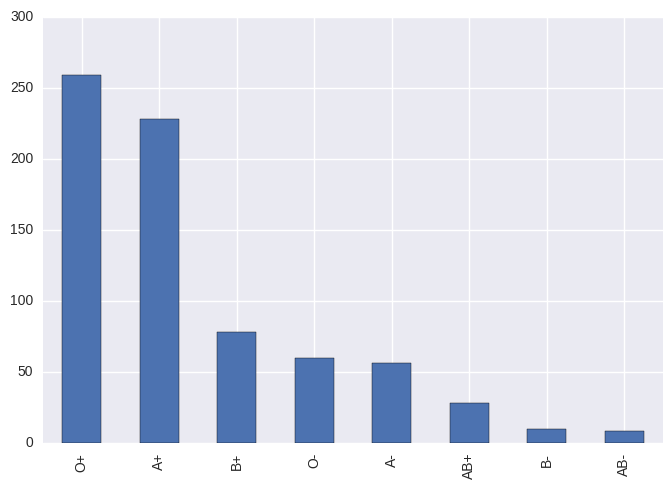

In [5]:
dataBloodType['blood_type'].value_counts().plot(kind='bar')

In [6]:
# Getting phenotypes for huIDs that have associated genotypes

g2 = lambda x:x[0:x.find(b"-")]
results = [g2(i).decode("utf-8").lower() for i in ohinfo]

df = pd.DataFrame(results,columns={'Sample'})
df['Number'] = df.index

In [7]:
df

,Sample,Number
0,hu011c57,0
1,hu016b28,1
2,hu01f73b,2
3,hu0211d6,3
4,hu025cea,4
5,hu032c04,5
6,hu03e3d2,6
7,hu040c0a,7
8,hu0486d6,8
9,hu04df3c,9


In [8]:
dataBloodType.human_id = dataBloodType.human_id.str.lower()
df2 =  df.merge(dataBloodType,left_on = 'Sample', right_on='human_id', how='inner')
del dataBloodType
df2

,Sample,Number,human_id,blood_type,A,B,Rh
0,hu016b28,1,hu016b28,A+,1,0,1
1,hu025cea,4,hu025cea,O-,0,0,0
2,hu040c0a,7,hu040c0a,A-,1,0,0
3,hu04df3c,9,hu04df3c,B+,0,1,1
4,hu04f220,10,hu04f220,B+,0,1,1
5,hu04fd18,11,hu04fd18,O+,0,0,1
6,hu050e9c,12,hu050e9c,O-,0,0,0
7,hu05fd49,13,hu05fd49,A+,1,0,1
8,hu0a4518,16,hu0a4518,B+,0,1,1
9,hu0d1fa1,18,hu0d1fa1,O+,0,0,1


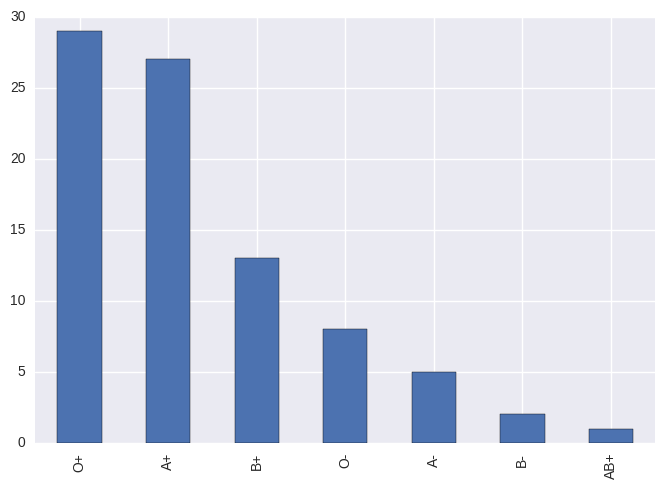

In [9]:
df2['blood_type'].value_counts().plot(kind='bar')

In [10]:
df2['blood_type'].value_counts()
del df

In [11]:
# Get genotypes that have associated blood type phenotype


idx = df2['Number'].values

Xtrain = Xtrain[idx,:] 
Xtrain.shape

(85, 2564734)

In [12]:
# Remove tiles (columns) that don't have more than 1 tile varient at every position
# Actually probably will want to technically do this before the one-hot, so I am keeping these in for the moment

min_indicator = np.amin(Xtrain, axis=0)
max_indicator = np.amax(Xtrain, axis=0)

sameTile = min_indicator == max_indicator
skipTile = ~sameTile

Xtrain = Xtrain[:,skipTile]
justVarPathsNew = justVarPaths[skipTile]

Xtrain.shape

(85, 1345043)

In [13]:
# Scaling the Training Data

Xtrain = preprocessing.scale(Xtrain.astype('double'))


In [14]:
y = df2.A.values

del df2

In [15]:
Xtrain

array([[-0.10910895, -0.15523011,  0.10910895, ...,  0.15523011,
        -0.10910895, -0.10910895],
       [-0.10910895, -0.15523011,  0.10910895, ...,  0.15523011,
        -0.10910895, -0.10910895],
       [-0.10910895, -0.15523011,  0.10910895, ...,  0.15523011,
        -0.10910895, -0.10910895],
       ..., 
       [-0.10910895, -0.15523011,  0.10910895, ...,  0.15523011,
        -0.10910895, -0.10910895],
       [-0.10910895, -0.15523011,  0.10910895, ...,  0.15523011,
        -0.10910895, -0.10910895],
       [-0.10910895, -0.15523011,  0.10910895, ...,  0.15523011,
        -0.10910895, -0.10910895]])

In [16]:
# C = 0.01  # SVM regularization parameter
classifier = svm.LinearSVC(penalty='l1', dual=False, C=0.01)
svc = classifier.fit(Xtrain, y)

In [17]:
svc.coef_.max()

0.1086340648821788

In [18]:
np.nonzero(svc.coef_)[1].shape

(1,)

In [19]:
idxNZ = np.nonzero(svc.coef_)

In [20]:
n = 10
scores = cross_val_score(classifier, Xtrain, y, cv=n)

In [21]:
scores

array([ 0.9  ,  0.9  ,  1.   ,  0.875,  1.   ,  0.875,  0.75 ,  0.875,
        0.875,  0.875])

In [22]:
scores.mean()

0.89250000000000007

In [23]:
scores.std()*2

0.1342572158209755

In [24]:
sum(y)

33

In [25]:
100-16

84

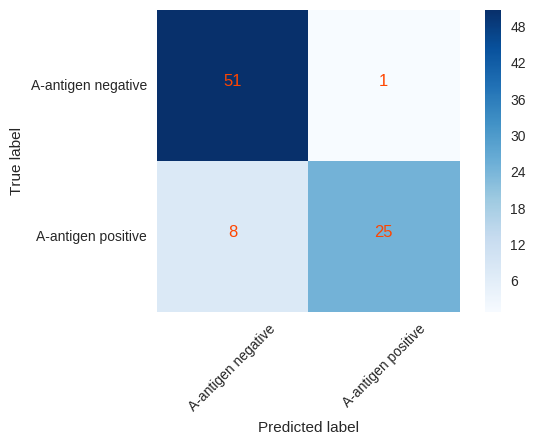

In [26]:
y_pred = svc.predict(Xtrain)
cnf_matrix = confusion_matrix(y, y_pred)

plt.imshow(cnf_matrix,interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')

classes = ['A-antigen negative','A-antigen positive']

plt.grid('off')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(cnf_matrix.shape[0]):
 for j in  range(cnf_matrix.shape[1]):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color= "orangered")

plt.gcf().subplots_adjust(left=0.25, bottom =0.35)
plt.savefig('Images/A_Confusion1.png',format='png',dpi=300)

In [27]:
coefPaths = justVarPathsNew[idxNZ[1]]

In [28]:
coefPaths

array([473958169], dtype=int32)

In [29]:
vhex = np.vectorize(hex)
tile_path = np.trunc(coefPaths/(16**5))
tile_step = np.trunc((coefPaths - tile_path*16**5)/2)
tile_phase = np.trunc((coefPaths- tile_path*16**5 - 2*tile_step))
tile_path

array([ 452.])

In [30]:
vhex(tile_path.astype('int'))

array(['0x1c4'], 
      dtype='<U5')

In [31]:
vhex(tile_step.astype('int'))

array(['0x38c'], 
      dtype='<U5')

In [32]:
svc.coef_[idxNZ]

array([ 0.10863406])